<a href="https://colab.research.google.com/github/wiredastronaut/stableDiffusion/blob/main/Diffusion/Probabilistic-Models/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import torch.nn as nn
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


mean of swiss roll =0.1225,0.0823


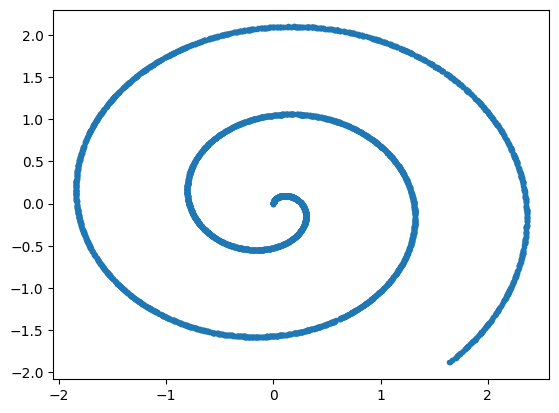

In [111]:
#Define swiss roll
length_phi = 15   #length of swiss roll in angular direction
sigma = 0.01  #noise strength
m = 5000     #number of samples
#create the dataset
phi = length_phi * np.random.rand(m)
xi = np.random.rand(m)
X = 1./6*(phi + sigma*xi)*np.sin(phi)
Y = 1./6*(phi + sigma*xi)*np.cos(phi)
swiss_roll = np.array([X, Y]).transpose()
# now display
print(f"mean of swiss roll ={np.mean(X):.4f},{np.mean(Y):.4f}")
plt.scatter(X, Y, marker=".")

In [112]:


class ReverseDiffusionNetwork(nn.Module):
    def __init__(self, input_dim, time_dim, hidden_dim=128, num_layers=3):
        """
        Neural network for approximating the reverse mean (mu_theta).
        Args:
            input_dim: Dimensionality of x_t.
            time_dim: Dimensionality of the time embedding.
            hidden_dim: Number of hidden units per layer.
            num_layers: Number of layers in the network.
        """

        #Base class
        super().__init__()

        # Define layers
        layers = []
        input_size = input_dim + time_dim  # x_t + time embedding as input
        for _ in range(num_layers):
            #fully connected layer difnet = ReverseDiffusionNetwork(2, 1, 16, 3)
            layers.append(nn.Linear(input_size, hidden_dim))
            #add activation function
            layers.append(nn.ReLU())
            input_size = hidden_dim

        self.shared_layers = nn.Sequential(*layers)
        #Make the layers sequential
        #* -> that expands the individual layers so they can be taken as argumnets


        # Define separate heads for mean and log-variance
        self.mean_head = nn.Linear(hidden_dim, input_dim)  # Predict mu_theta
        self.logvar_head = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),  # Linear transformation
            nn.Sigmoid()                       # Apply sigmoid activation
        )
    def forward(self, x_t, t):
        # The inputs the sample at the given time, ie. x_t, and then the correpsonding time. The time piece
        # allows us to account for the learning schedule (ie. beta getting bigger/smaller through time)


        """
        Forward pass through the network. ie. not going forward in difusion, but going through the network to train it (confusing on a glance)
        Args:
            x_t: Noisy data at time t (batch_size, input_dim).
            t: Scalar time index (batch_size, time_dim).
        Returns:
            mu_theta: Predicted mean (batch_size, input_dim).
            log_sigma_theta: Predicted log-variance (batch_size, input_dim).
        """
        #next(self.parameters()):
        # retrieves the first parameter of the network. This let's us get the data type of it to 
        # ensure x_t is the correct data type
        x_t = x_t.to(next(self.parameters()).dtype)
        t = t.to(next(self.parameters()).dtype)

        # Combine x_t and time embedding
        input_data = torch.cat([x_t, t], dim=-1)
        shared_output = self.shared_layers(input_data)

        # Compute mean and log-variance
        mu_theta = self.mean_head(shared_output)
        log_sigma_theta = self.logvar_head(shared_output)

        return mu_theta, log_sigma_theta



In [113]:
torch.randn(16, 2)

tensor([[-0.0345,  1.7920],
        [ 0.4920, -0.3008],
        [ 1.2970, -1.8542],
        [-0.1218, -0.6809],
        [ 0.9048,  1.8935],
        [-0.6539, -0.5482],
        [ 0.1056,  0.0535],
        [-1.0433, -0.3492],
        [ 0.4070, -0.5470],
        [-0.4971,  0.7598],
        [-1.6872,  0.6310],
        [ 1.1818,  0.9169],
        [ 2.2470, -1.8010],
        [-0.2265,  0.7742],
        [-0.3419,  0.6476],
        [-1.4896, -2.3239]])

In [114]:
## Using an RBF:
# Radial basis function - real valued function who's output depends on the distance between the input and some fixed point. The best example is the gaussian - 
# where the input is some value close to the mean of the gaussian and the closer it is, the larger the value. Great!

'''Radial Basis Function N. N. 
Input: n-d input vector
RBF Neurons: The neurons represent a prototype vector from the traning set - the network finds the euclidean distance
between the input vector and each neuron's center.
Activation Function: RBF, closer to the center the higher the value!

Okay so let me make sure I have the gist of the RBF network. Essentially the inputs come in that look like <x,y,t> 
and I might have 100 of them. These get passed to say 16 RBF nodes, now the RBF node should give me a high "activation" 
if a given sample is near the mean, and low "activation if not (within the sigma). Each RBF takes in 3 inputs, but 
should only output a single value as each RBF represents a multi-variate gaussian which is a function of the <x,y,t> 
mean that is learned. So after the RBF layer I'll have a data structure of 100 features of dimension 16 - from there 
it is passed to the mean head and the variance head which is a simple fully connected neural network who is trying to
 condition the weights to predict the mean and the variances for each step.  

'''


class RBF_DiffusionNetork(nn.Module):
    def __init__(self, input_dim, time_dim, hidden_dim=128, num_layers=3):
        """
        Neural network for approximating the reverse mean (mu_theta).
        Args:
            input_dim: Dimensionality of x_t.
            time_dim: Dimensionality of the time embedding.
            hidden_dim: Number of hidden units per layer.
            num_layers: Number of layers in the network.
        """

        #Base class
        super().__init__()
        

        # Define layers
        layers = []
        input_size = input_dim + time_dim  # x_t + time embedding as input


        #Define a nice RBF layer
        # 16 centers
        self.centers = nn.Parameter(torch.randn(hidden_dim, input_size))
        #The one makes it broadcastable
        self.sigma = nn.Parameter(torch.ones(1, hidden_dim, input_size))

        # Define separate heads for mean and log-variance
        self.mean_head = nn.Linear(hidden_dim, input_dim)  # Predict mu_theta
        #Don't predict the log anymore
        self.logvar_head = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),  # Linear transformation
            nn.Sigmoid()                       # Apply sigmoid activation
        )
    def forward(self, x_t, t):       
        x_t = x_t.to(next(self.parameters()).dtype)
        t = t.to(next(self.parameters()).dtype)

        # Combine x_t and time embedding
        input_data = torch.cat([x_t, t], dim=-1)
        input_data = input_data.unsqueeze(1) 
        # Goes from Nx3 -> Nx1x3
        rbf_dist = torch.sum((input_data - self.centers) ** 2 / (2 * self.sigma**2), dim=-1)
        rbf_output = torch.exp(-rbf_dist)

        # Compute mean and log-variance
        mu_theta = self.mean_head(rbf_output)
        log_sigma_theta = self.logvar_head(rbf_output)

        return mu_theta, log_sigma_theta



In [115]:
class BetaSchedule(nn.Module):
    def __init__(self, T):
        super().__init__()
        #Create nn parameters of theta
        self.theta_beta = nn.Parameter(torch.linspace(-10, -2, steps=T))
        self.beta_min = 1e-6
        self.beta_max = 1 - 1e-6
    
    def forward(self):
        betas = torch.sigmoid(self.theta_beta) * (self.beta_max - self.beta_min) + self.beta_min
        return betas

In [116]:
def true_posterior(alphas, betas, x0, xt, idx):
  mu = ((torch.sqrt(alphas[idx-1]) * betas[idx])/(1 - alphas[idx]) * x0) + (torch.sqrt(1-betas[idx]) * (1 - alphas[idx-1])/(1 - alphas[idx])) * xt
  beta_hat = (1 - alphas[idx-1]) * betas[idx]/(1 - alphas[idx])
  print(f"beta_hat is {beta_hat}")


  #variance = variance*torch.randn_like(mu, device=device)
  variance = torch.full_like(mu, beta_hat.item)
  
  return (mu, variance, beta_hat)

In [117]:
def kl_divergence(true_mu, est_mu, log_true_var, log_est_var):
  
  est_var = torch.exp(log_est_var)
  true_var = torch.exp(log_true_var)
  assert true_var.shape == est_var.shape, "true_var and est_var must have the same shape!"
  assert log_true_var.shape == log_est_var.shape, "log_true_var and log_est_var must have the same shape!"
  mean_loss = torch.sum((true_mu - est_mu) ** 2/ est_var, dim = 1)
  var_loss = torch.sum(log_est_var - log_true_var + (true_var / est_var) - 1, dim=1)
  print(f"true_var mean: {true_var.mean().item()}, est_var mean: {est_var.mean().item()}")
  print(f"true_mu mean: {true_mu.mean().item()}, est_mu mean: {est_mu.mean().item()}")
  print(f"average of loss  {torch.mean(mean_loss)}, max of loss {torch.max(mean_loss)}, min of loss {torch.min(mean_loss)}")
  print(f"average of var loss  {torch.mean(var_loss)}, max of loss {torch.max(var_loss)}, min of loss {torch.min(var_loss)}")
  return torch.mean(0.5*(mean_loss + var_loss))
  


In [145]:
def inference(T, net, starting_dist, bPlotIntermmediate=False):
    x_t = starting_dist
    for i in range(T-1, -1, -1):
        t = (i+1)/T
        t = torch.full(( x_t.shape[0], 1), t, device=device)    
        [mu_pred, var_pred] = net.forward(x_t, t)


        #This represents the forward diffusion process.
        #x_t = torch.sqrt(1 - beta_t) * mu_pred + torch.sqrt(beta_t) * var_pred
        #The backwards, because we learn it is a little more straight forward
        # Reverse diffusion step
        noise = torch.randn_like(x_t)
        x_t = mu_pred
        if i > 0:  # Add noise except at the final step
            x_t += torch.sqrt(var_pred + 1e-8) * noise
        if bPlotIntermmediate and T % 5 == 0:
            x_tn = mu_pred.cpu().detach().numpy()
            fig = plt.figure(figsize = (5, 5))
            plt.scatter(x_tn[:, 0], x_tn[:,1], marker='.')
            plt.show()

    x_tn = mu_pred.cpu().detach().numpy()
    fig = plt.figure(figsize = (5, 5))
    plt.scatter(x_tn[:, 0], x_tn[:,1], marker='.')
    plt.show()

Epoch 900 total_loss = 43832.472256401044
tensor([0.0001, 0.0002, 0.0002, 0.0003, 0.0003, 0.0003, 0.0004, 0.0004, 0.0005,
        0.0006, 0.0007, 0.0008, 0.0010, 0.0012, 0.0015, 0.0018, 0.0022, 0.0027,
        0.0032, 0.0038, 0.0045, 0.0054, 0.0065, 0.0078, 0.0093, 0.0111, 0.0133,
        0.0157, 0.0184, 0.0215, 0.0253, 0.0301, 0.0360, 0.0429, 0.0506, 0.0585,
        0.0664, 0.0739, 0.0813, 0.0878], grad_fn=<AddBackward0>)


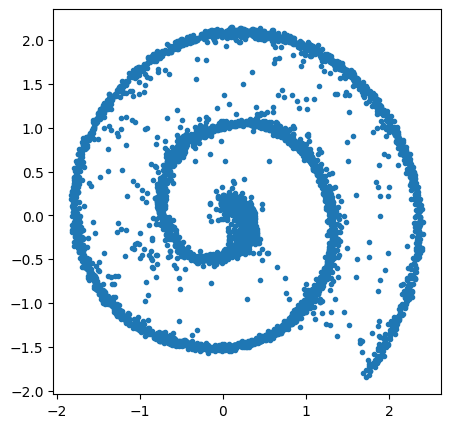

In [130]:
from IPython.display import clear_output
T = 40
device = 'cuda'
#betas = torch.linspace(0.001, 0.1, steps=T, device=device)
#betas = torch.tensor(1/(T - np.arange(1, T+1) + 1))
betas = torch.tensor([0.0400, 0.0467, 0.0588, 0.0791, 0.1113, 0.1607, 0.2315, 0.3238, 0.4313,
        0.5419, 0.6414, 0.7195, 0.7740, 0.8093, 0.8314, 0.8456, 0.8549, 0.8613,
        0.8659, 0.8694, 0.8720, 0.8741, 0.8759, 0.8772, 0.8784, 0.8794, 0.8802,
        0.8809, 0.8814, 0.8820, 0.8824, 0.8828, 0.8831, 0.8834, 0.8837, 0.8839,
        0.8841, 0.8843, 0.8845, 0.8846])

#betas = 0.5 * .999*(1 - torch.cos(torch.linspace(0, torch.pi, T)))+.0001
#betas = (torch.nn.Parameter(betas, requires_grad=True))
#betas = (torch.nn.Parameter(betas))


beta_sched = BetaSchedule(T) 
difnet = RBF_DiffusionNetork(2, 1, 256, 3)
#difnet = ReverseDiffusionNetwork(2, 1, 128, 3)
difnet = difnet.to(device)

#x0, the initial data is our swiss roll (identified above)
x0 = (torch.from_numpy(np.vstack((X, Y))).T).to(device)
#initialize
x_t = x0
noise = torch.randn_like(x_t)
optimizer = torch.optim.Adam([
    {'params': difnet.parameters(), 'lr': 0.01},
    {'params': beta_sched.parameters(), 'lr': 0.0001}  # Smaller LR for betas
])

#optimizer = torch.optim.Adam([
#    {'params': difnet.parameters(), 'lr': 0.01},
#    {'params': beta_sched.parameters(), 'lr': 0.01}  # Smaller LR for betas
#])
fixed_noise = torch.randn_like(x_t, device=device)
num_epochs = 1000
d = 2
lambda_var = 0.0
loss_array = np.zeros((num_epochs))
variance_avg = np.zeros((num_epochs))
variance_variance= np.zeros((num_epochs))
term1s = np.zeros((num_epochs))
term2s= np.zeros((num_epochs))
term3s= np.zeros((num_epochs))
for epoch in range(num_epochs):

  x_t = (torch.from_numpy(np.vstack((X, Y))).T).to(device)
  total_loss = 0
  tmp_term1 = np.zeros((T))
  tmp_term2 = np.zeros((T))
  tmp_term3 = np.zeros((T))
  for i in range(T):  
    betas = beta_sched.forward()
    alphas = torch.cumprod(1 - betas, dim=0)
    #Equation 3
    noise = torch.randn_like(x_t, device=device)
    #x_t = torch.sqrt(1 - betas[i]) * x_t + torch.sqrt(betas[i])  * noise
    #x_t = x_t.detach()
    with torch.no_grad():
      x_t = torch.sqrt(1 - betas[i]) * x_t + torch.sqrt(betas[i]) * noise
    t = (i+1)/T
    t = torch.full(( x_t.shape[0], 1), t, device=device)    
    [mu_p, var_p] = difnet.forward(x_t, t)
    
    
    if i == 0:
      kl_loss = torch.sum((x0 - mu_p)**2)
      predicted_swiss_roll = mu_p
      predicted_sr_var = var_p
      tmp_term3[i] = kl_loss
    else:
      #This formula addresses kind of a fundamental concern of comparing x0 to x1, but predicting on x1. It helps time sync the two distributions
      #see eq. 25 in arxiv
      mu_tilde = torch.sqrt(alphas[i-1])/(1 - alphas[i]) * betas[i] * x0 + torch.sqrt(1 - betas[i]) * (1- alphas[i-1])/(1 - alphas[i]) * x_t
      beta_tilde = (1 - alphas[i-1])/(1 - alphas[i]) * betas[i]
      var_q = beta_tilde
      #print(f"Step {i}: mean(var_q)={torch.mean(var_q):.4f}, max(var_q)={torch.max(var_q):.4f}, min(var_q)={torch.min(var_q):.4f}")

      mu_q = mu_tilde
      #kl divergence
      det_var_p = var_p[:,0] * var_p[:, 1]
      det_var_q = var_q**2
      term1 = torch.log(det_var_p/det_var_q)
      term2 = torch.sum(var_q/var_p, dim=1)
      #var p is a Nx2 vector where it represents the trace of the covariance matrix
      #sigma p is the standard deviation of that, but the same dimension

      #Now b/c the default seems to be element-wise multiplication this carries out
      #the operations as expected.
      term3 = torch.sum((mu_q - mu_p) ** 2 /var_p, dim=1)
      var_reg_loss = torch.sum((var_p - var_q)**2)
      kl_loss = torch.sum(1/2 * (term1 - d + term2 + term3)) + lambda_var * var_reg_loss
      tmp_term1[i] = torch.sum(term1)
      tmp_term2[i] = torch.sum(term2)
      tmp_term3[i] = torch.sum(term3)
    total_loss += kl_loss



    optimizer.zero_grad()
    kl_loss.backward()
    optimizer.step()    

      
    #betas.data.clamp_(min=0, max=0.999999)
    #betas = betas.detach().clamp_(min=0, max=0.999999).requires_grad_(True)
  if epoch % int(num_epochs * .1) == 0:
    clear_output()
    print(f"Epoch {epoch} total_loss = {total_loss.detach()}")
    print(betas)
    inference(T, difnet, x_t)



  term1s[epoch] = np.mean(tmp_term1)
  term2s[epoch] = np.mean(tmp_term2)
  term3s[epoch] = np.mean(tmp_term3)

  loss_array[epoch] = total_loss.detach()
  variance_avg[epoch] = torch.mean(predicted_sr_var)
  variance_variance[epoch] = torch.std(predicted_sr_var)







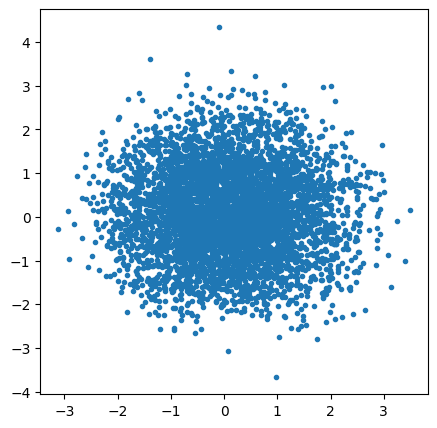

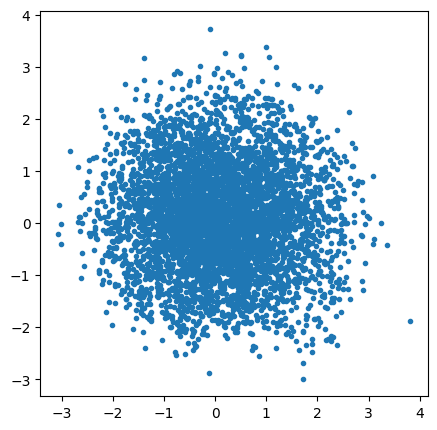

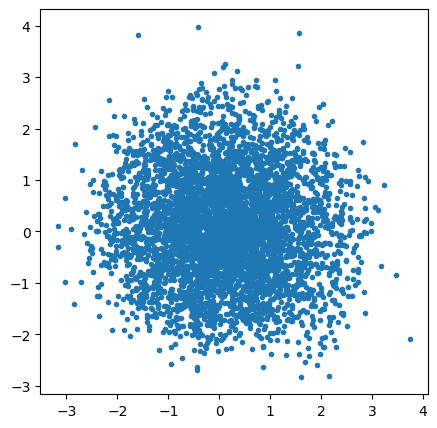

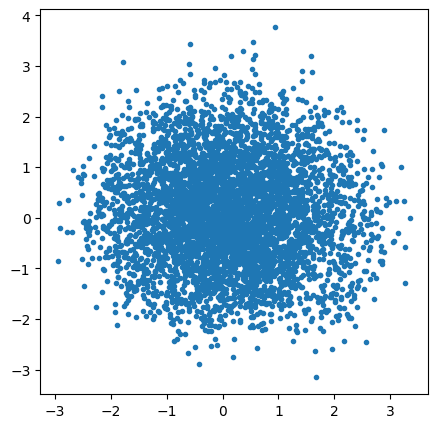

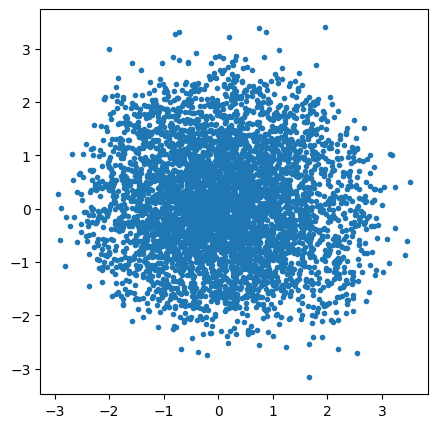

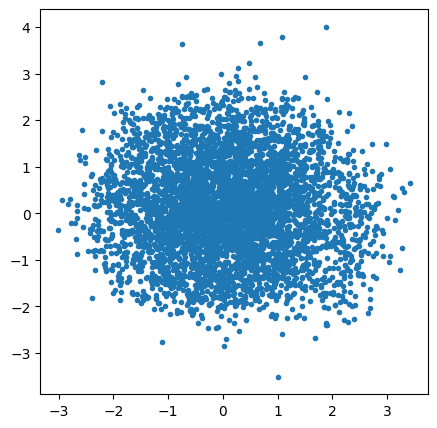

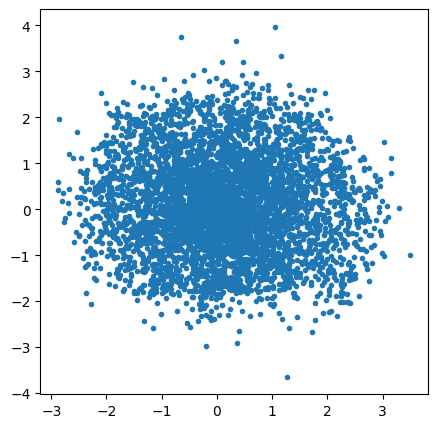

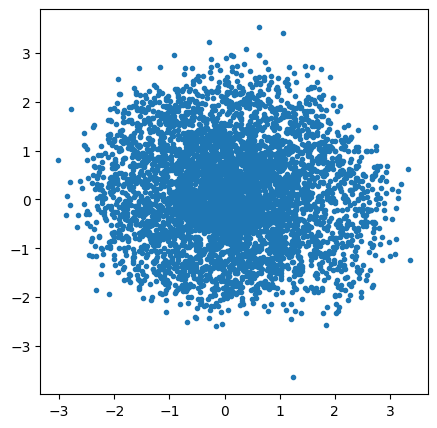

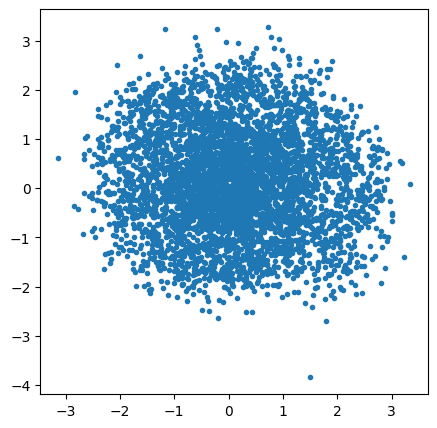

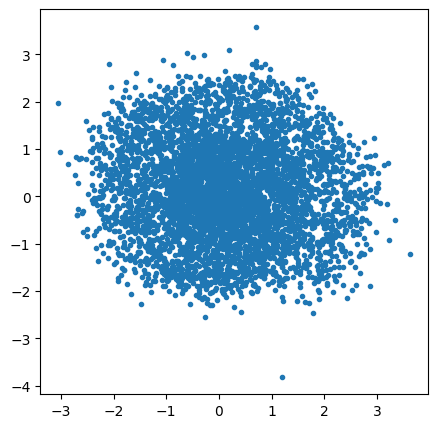

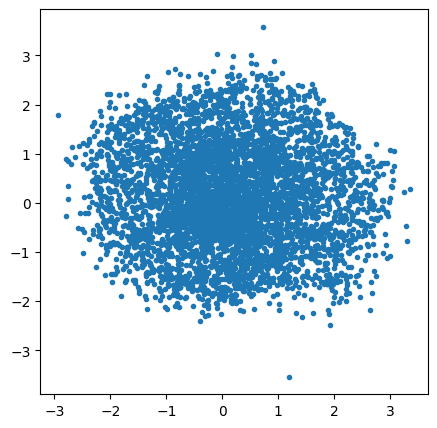

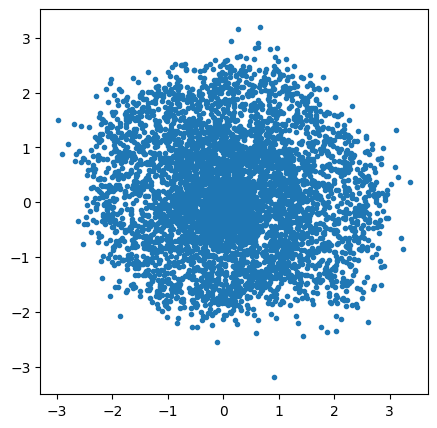

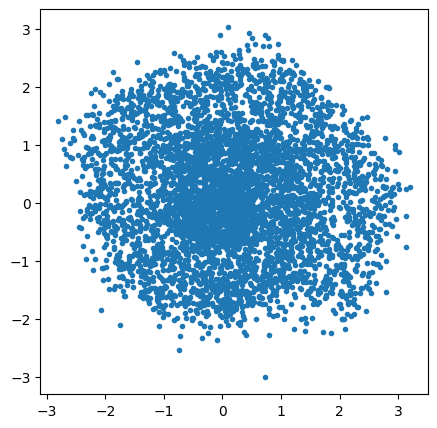

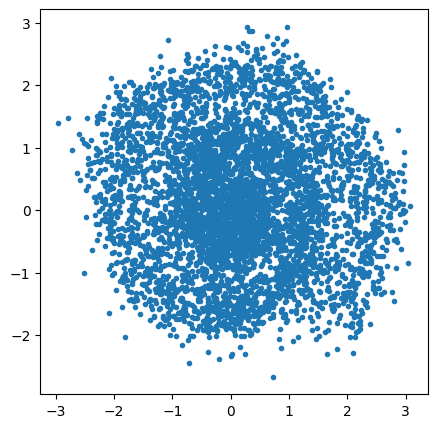

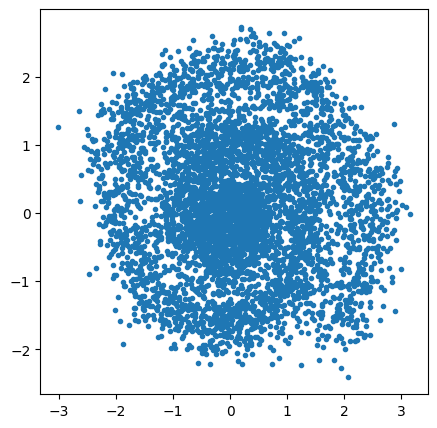

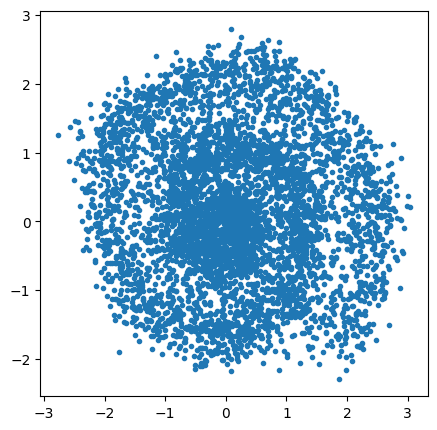

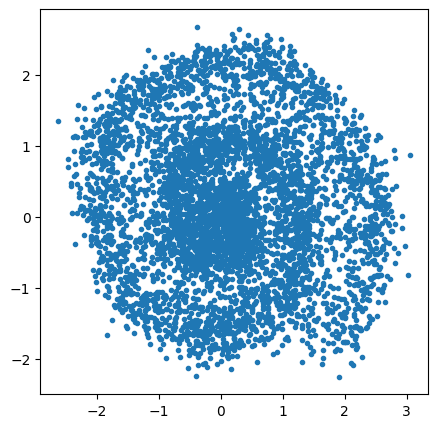

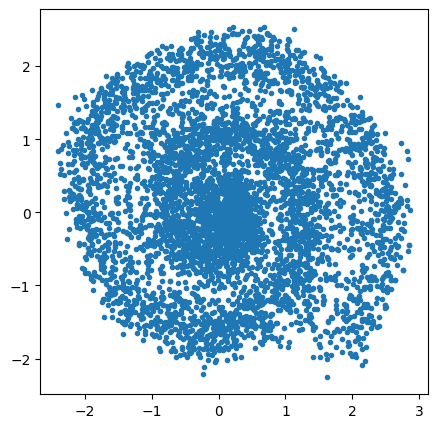

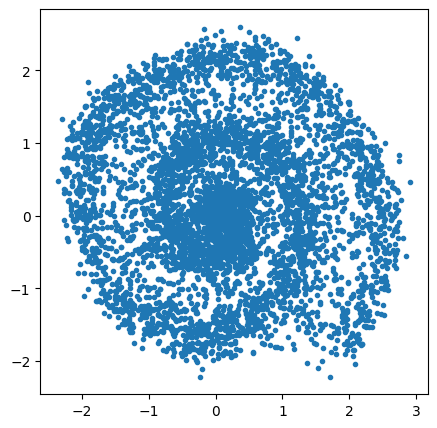

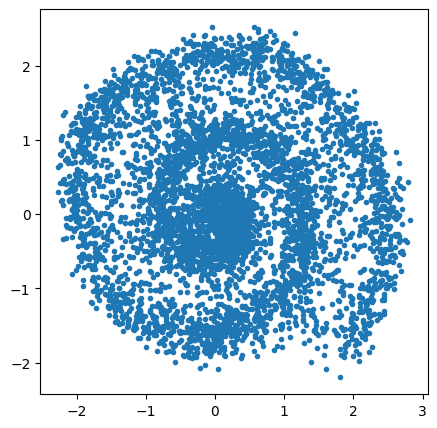

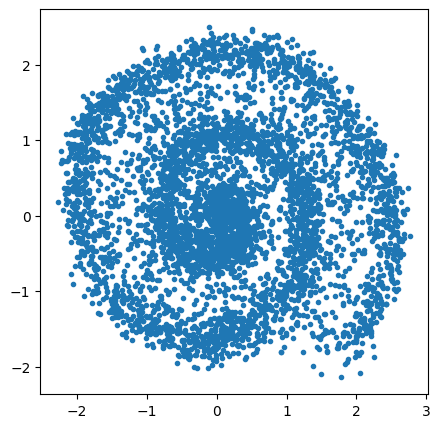

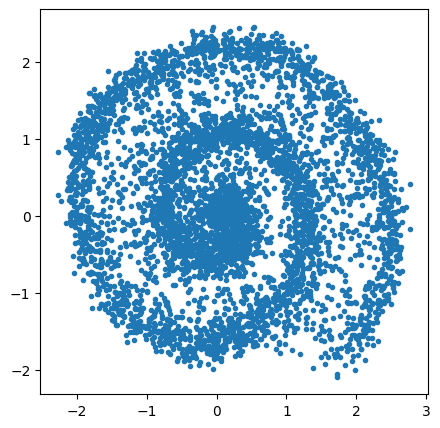

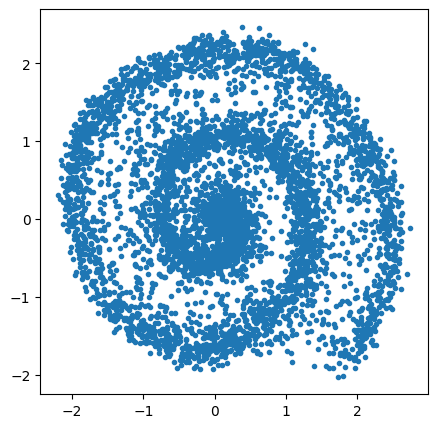

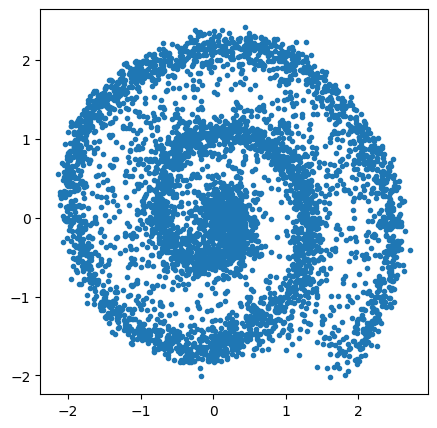

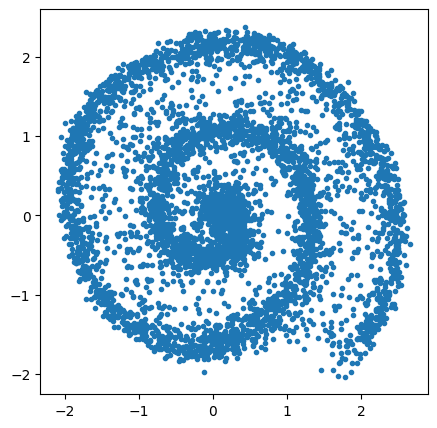

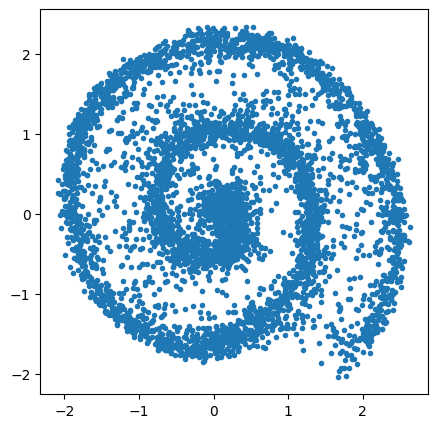

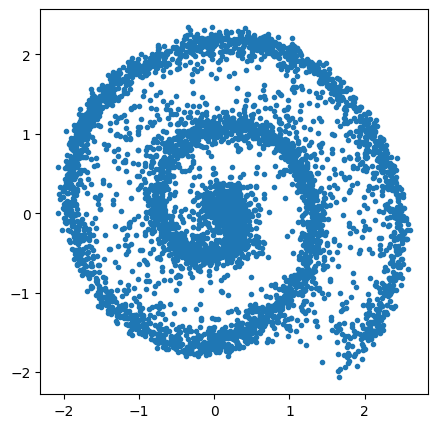

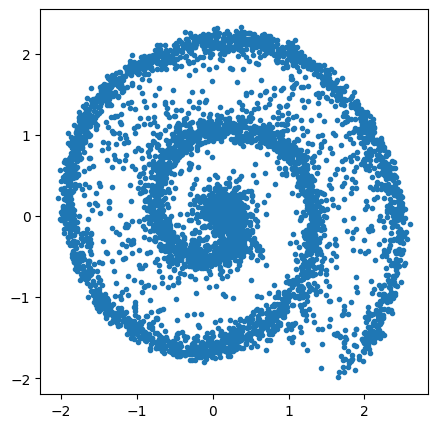

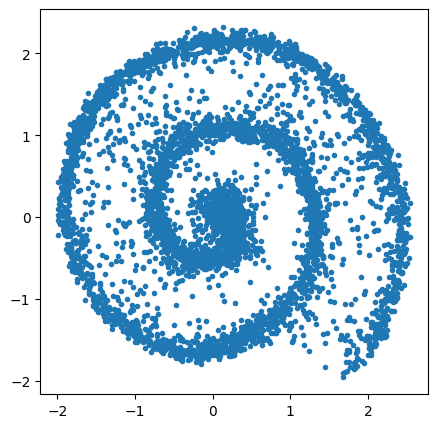

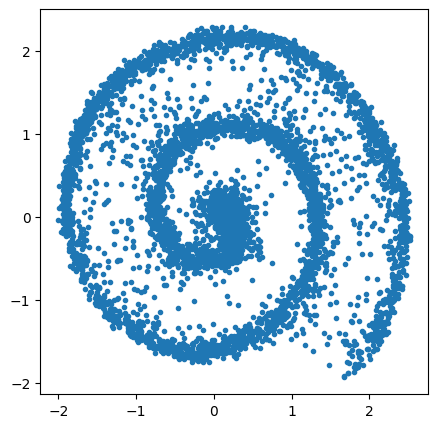

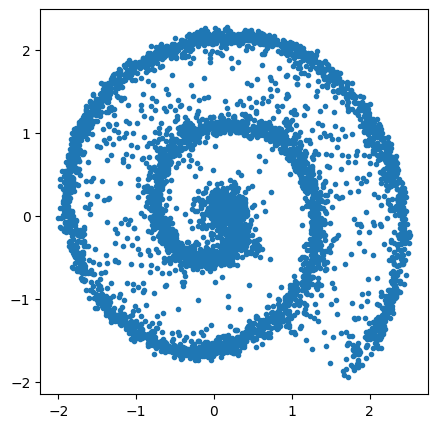

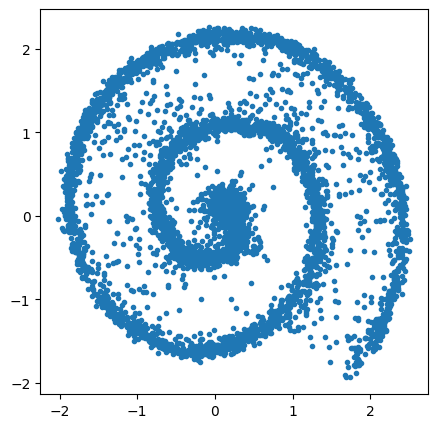

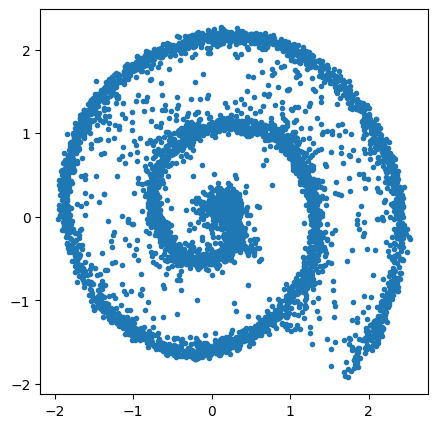

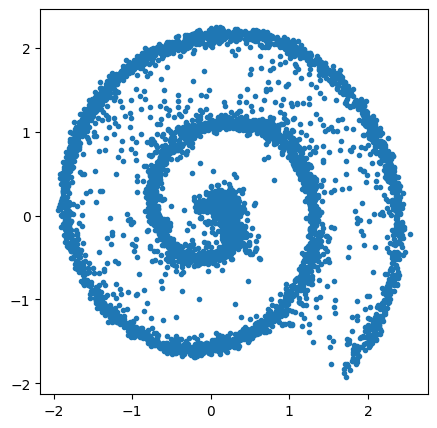

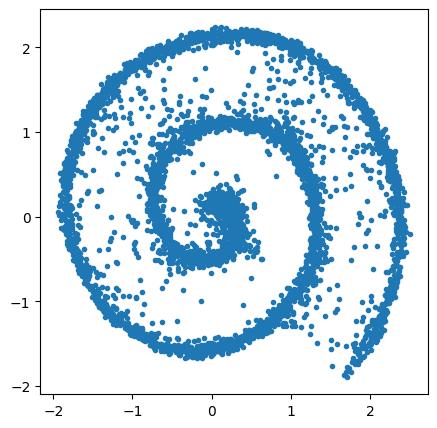

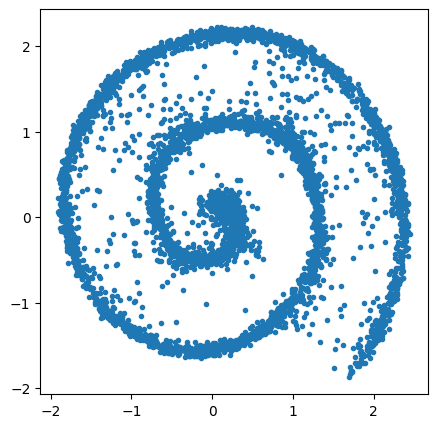

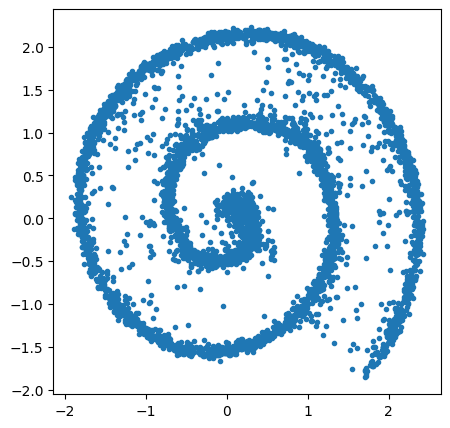

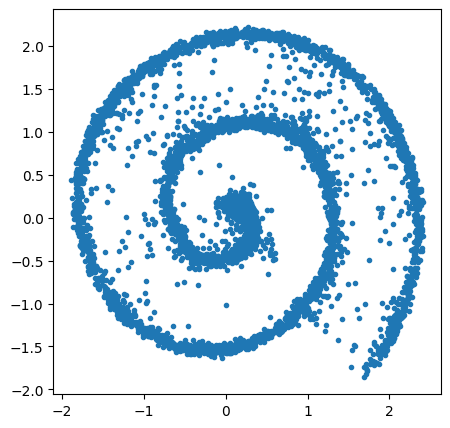

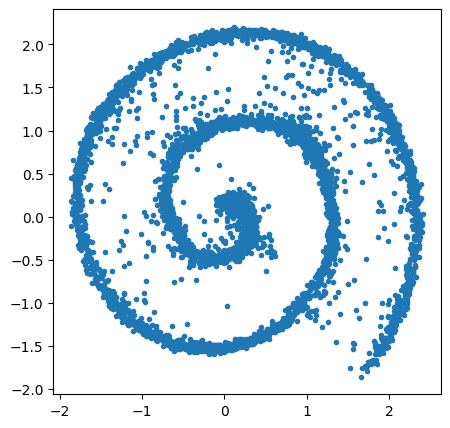

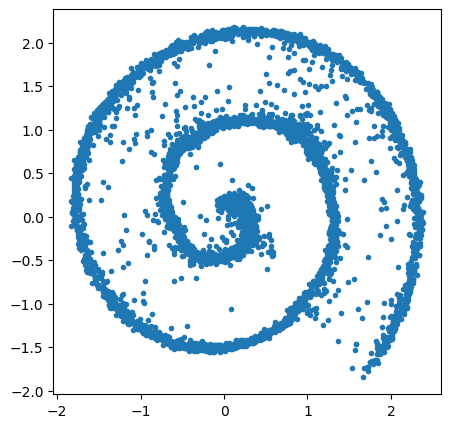

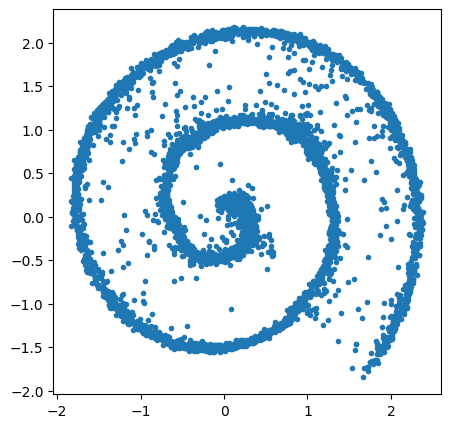

In [146]:
inference(T, difnet, x_t, bPlotIntermmediate=True)

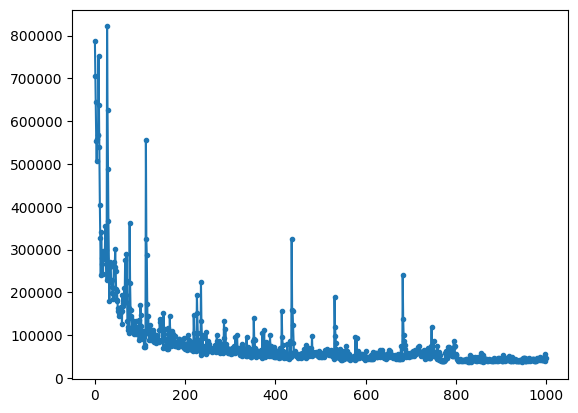

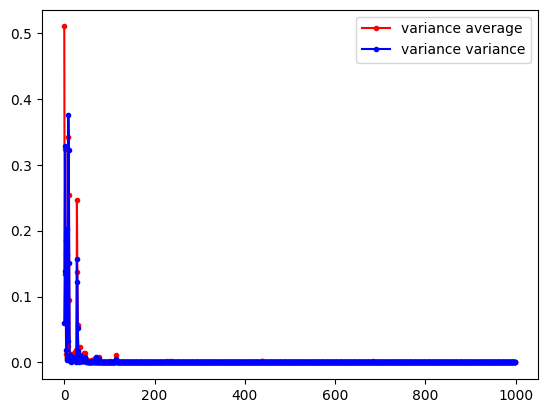

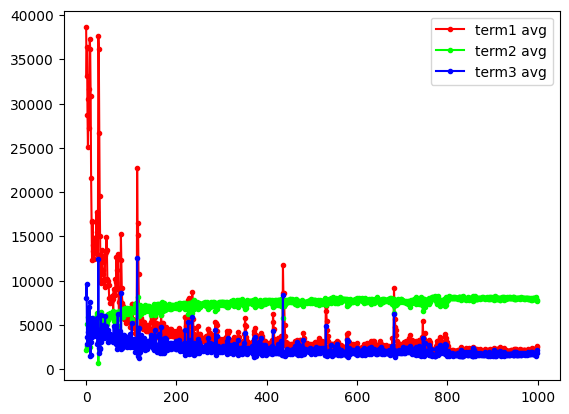

In [132]:
fig = plt.figure()
plt.plot(loss_array, marker=".")

plt.show()
fig = plt.figure()
plt.plot(variance_avg, marker=".", color=[1, 0, 0])
plt.plot(variance_variance, marker=".", color=[0, 0, 1])
plt.legend(['variance average', 'variance variance'])
plt.show()

fig = plt.figure()
plt.plot(term1s, marker=".", color=[1, 0, 0])
plt.plot(term2s, marker=".", color=[0, 1, 0])
plt.plot(term3s, marker=".", color=[0, 0, 1])

plt.legend(['term1 avg', 'term2 avg', 'term3 avg'])
plt.show()

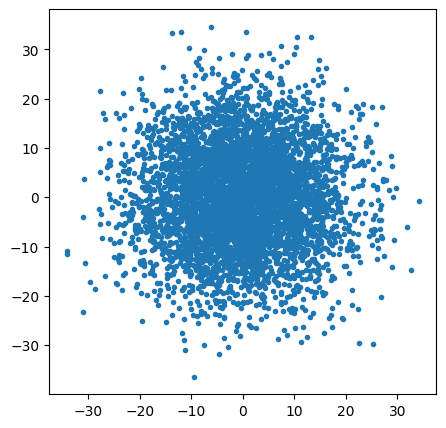

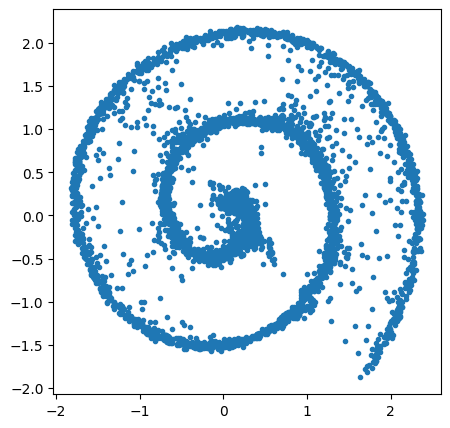

In [140]:
#After a given epoch the final distribution should represent the 
#final forward diffusion state (ie. the starting point for going backward)
#we can generate it by using the mean and std of it
noise = torch.randn_like(x_t, device=device)
XT = 0 + torch.std(x_t) * noise*10 #(this is the same as the final xt)
XTn = XT.cpu().detach().numpy()
fig = plt.figure(figsize = (5, 5))
plt.scatter(XTn[:, 0], XTn[:,1], marker='.')
inference(T, difnet, XT)

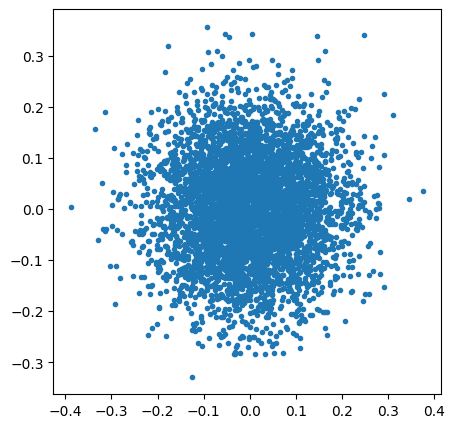

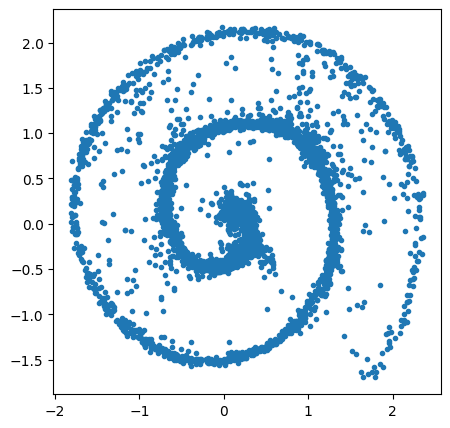

In [141]:
#After a given epoch the final distribution should represent the 
#final forward diffusion state (ie. the starting point for going backward)
#we can generate it by using the mean and std of it
noise = torch.randn_like(x_t, device=device)
XT = 0 + torch.std(x_t) * noise*.1 #(this is the same as the final xt)
XTn = XT.cpu().detach().numpy()
fig = plt.figure(figsize = (5, 5))
plt.scatter(XTn[:, 0], XTn[:,1], marker='.')
inference(T, difnet, XT)

